In [223]:
import torch
from torch import nn
import torchvision
from torch.utils import data
from torchvision import transforms
from d2l import torch as d2l
from torch.nn import functional as F
from torch.optim import lr_scheduler
import math
def get_dataloader_workers():
    return 4
def load_data_CIFAR100(batch_size,train_augs=None,test_augs=None,resize=None):  
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    if train_augs == None:
        CIFAR100_train = torchvision.datasets.CIFAR100(root="/root/autodl-tmp/data",train=True,transform=trans,download=True)
        CIFAR100_test = torchvision.datasets.CIFAR100(root="/root/autodl-tmp/data",train=False,transform=trans,download=True)
    else:
        CIFAR100_train = torchvision.datasets.CIFAR100(root="/root/autodl-tmp/data",train=True,transform=train_augs,download=True)
        CIFAR100_test = torchvision.datasets.CIFAR100(root="/root/autodl-tmp/data",train=False,transform=test_augs,download=True)
    return (data.DataLoader(CIFAR100_train, batch_size, shuffle=True,num_workers=get_dataloader_workers()),
            data.DataLoader(CIFAR100_test, batch_size, shuffle=False,num_workers=get_dataloader_workers()))

In [224]:
class Residual(nn.Module):  
    def __init__(self, input_channels, num_channels, use_1x1conv=False,
                 strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels, kernel_size=3,
                               padding=1, stride=strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels, kernel_size=3,
                               padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels,
                                   kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

In [225]:
def resnet_block(input_channels, num_channels, num_residuals,
                 first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(
                Residual(input_channels, num_channels, use_1x1conv=True,
                         strides=2))
        else:
            blk.append(Residual(num_channels, num_channels))
    return blk
# b1 = nn.Sequential(nn.Conv2d(3, 64, kernel_size=5, padding=2),
#                    nn.BatchNorm2d(64), nn.ReLU(),
#                    nn.MaxPool2d(kernel_size=2, stride=2))
# b2 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True))
# b3 = nn.Sequential(*resnet_block(64, 128, 2))
# b4 = nn.Sequential(*resnet_block(128, 256, 2))
# b5 = nn.Sequential(*resnet_block(256, 512, 2))

# net = nn.Sequential(b1, b2,nn.Dropout2d(0.3) ,b3, b4 ,nn.Dropout2d(0.3),b5,nn.AdaptiveAvgPool2d((1, 1)),
#                     nn.Flatten(),nn.Linear(512,286),nn.ReLU(),nn.Dropout(0.3),
#                     nn.Linear(286,100))

# b1 = nn.Sequential(nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
#                    nn.BatchNorm2d(64), nn.ReLU(),
#                    nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
# b2 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True))
# b3 = nn.Sequential(*resnet_block(64, 128, 2))
# b4 = nn.Sequential(*resnet_block(128, 256, 2))
# b5 = nn.Sequential(*resnet_block(256, 512, 2))

# net = nn.Sequential(b1, b2, b3, b4, b5, nn.AdaptiveAvgPool2d((1, 1)),
#                     nn.Flatten(), nn.Linear(512, 100))

In [226]:
finetune_net = torchvision.models.resnet18(pretrained=True)
finetune_net.fc = nn.Linear(finetune_net.fc.in_features, 100)
nn.init.xavier_uniform_(finetune_net.fc.weight)

/root/miniconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/miniconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Parameter containing:
tensor([[-0.0327,  0.0573, -0.0512,  ..., -0.0877, -0.0816, -0.0843],
        [-0.0330, -0.0380,  0.0553,  ..., -0.0775,  0.0547, -0.0950],
        [-0.0473, -0.0728, -0.0699,  ..., -0.0555,  0.0811, -0.0874],
        ...,
        [ 0.0033,  0.0401,  0.0639,  ...,  0.0073,  0.0732, -0.0947],
        [ 0.0466,  0.0416, -0.0920,  ..., -0.0928, -0.0876, -0.0924],
        [ 0.0548, -0.0634,  0.0250,  ...,  0.0173,  0.0272, -0.0553]],
       requires_grad=True)

In [227]:
# X = torch.rand(size=(1, 3, 32,32))
# for layer in net:
#     X = layer(X)
#     print(layer.__class__.__name__, 'output shape:\t', X.shape)

In [228]:
class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, eps=0.1, reduction='mean', ignore_index=-100):
        super(LabelSmoothingCrossEntropy, self).__init__()
        self.eps = eps
        self.reduction = reduction
        self.ignore_index = ignore_index

    def forward(self, output, target):
        c = output.size()[-1]
        log_pred = torch.log_softmax(output, dim=-1)
        if self.reduction == 'sum':
            loss = -log_pred.sum()
        else:
            loss = -log_pred.sum(dim=-1)
            if self.reduction == 'mean':
                loss = loss.mean()


        return loss * self.eps / c + (1 - self.eps) * torch.nn.functional.nll_loss(log_pred, target,reduction=self.reduction,ignore_index=self.ignore_index)

In [229]:
def train(net, train_iter, test_iter, num_epochs, loss, trainer, device,scheduler=None):
    # def init_weights(m):
    #     if type(m) == nn.Linear or type(m) == nn.Conv2d:
    #         nn.init.xavier_uniform_(m.weight)
    # net.apply(init_weights)
    # print('training on', device)
    net.to(device)
    loss = loss
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(4)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            X,y=features,labels
            X = X.to(device)
            y = y.to(device)
            net.train()
            trainer.zero_grad()
            pred = net(X)
            l = loss(pred, y)
            l.sum().backward()
            trainer.step()
            train_loss_sum = l.sum()
            train_acc_sum = d2l.accuracy(pred, y)
            metric.add(train_loss_sum, train_acc_sum, labels.shape[0], labels.numel())
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[2], metric[1] / metric[3],
                              None))
        test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
        if scheduler:
            if scheduler.__module__==lr_scheduler.__name__:
                scheduler.step()
            else:
                for param_group in trainer.param_groups:
                    param_group['lr']=scheduler(epoch)
                    
            
    print(f'loss {metric[0] / metric[2]:.3f}, train acc '
          f'{metric[1] / metric[3]:.3f}, test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec on '
          f'{str(device)}')

In [230]:
def train_fine_tuning(net, train_iter, test_iter,lr, num_epochs, loss, device,
                      scheduler=None,
                      param_group=True):
    if param_group:
        params_1x = [
            param for name, param in net.named_parameters()
            if name not in ["fc.weight", "fc.bias"]]
        trainer = torch.optim.Adam([{'params': params_1x},
                                   {'params': net.fc.parameters(),
                                    'lr': lr * 10}],
                                  lr=lr,weight_decay=0.001)
    else:
        trainer = torch.optim.Adam(net.parameters(), lr=lr,weight_decay=0.001)
    train(net, train_iter, test_iter, num_epochs, loss, trainer, device)

In [231]:
class CosineScheduler:
    def __init__(self, max_update, base_lr=0.01, final_lr=0,
        warmup_steps=0, warmup_begin_lr=0):
        self.base_lr_orig = base_lr
        self.max_update = max_update
        self.final_lr = final_lr
        self.warmup_steps = warmup_steps
        self.warmup_begin_lr = warmup_begin_lr
        self.max_steps = self.max_update - self.warmup_steps
    def get_warmup_lr(self, epoch):
        increase = (self.base_lr_orig - self.warmup_begin_lr) * float(epoch) / float(self.warmup_steps)
        return self.warmup_begin_lr + increase
    def __call__(self, epoch):
        if epoch < self.warmup_steps:
            return self.get_warmup_lr(epoch)
        if epoch <= self.max_update:
            self.base_lr = self.final_lr + (self.base_lr_orig - self.final_lr) * (1 + math.cos(
                math.pi * (epoch - self.warmup_steps) / self.max_steps)) / 2
        return self.base_lr


In [232]:
class SquareRootScheduler:
    def __init__(self, lr=0.1):
        self.lr=lr
    def __call__(self, num_update):
        return self.lr*pow(num_update+1.0,-0.5)

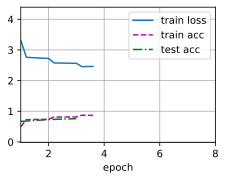

In [233]:
lr,num_epochs, batch_size =5e-5, 8, 128
mean = [0.5070751592371323, 0.48654887331495095, 0.4409178433670343]
std = [0.2673342858792401, 0.2564384629170883, 0.27615047132568404]
train_augs =transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    # torchvision.transforms.RandomHorizontalFlip(),
    # torchvision.transforms.ColorJitter(brightness=0, contrast=0, saturation=0,hue=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])
test_augs=transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])
loss=nn.CrossEntropyLoss(reduction="none",label_smoothing=0.1)
device=d2l.try_gpu()
net=finetune_net
train_iter, test_iter = load_data_CIFAR100(batch_size,train_augs=train_augs,test_augs=test_augs)
train_fine_tuning(net, train_iter, test_iter,lr, num_epochs,loss, device)